In [15]:
import pandas as pd 
rway_img_df  = pd.read_csv("collection_images_download.csv")
# EXTRACT BRAND FROM IMAGE NAME
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

#brand_keywords = ['rick owens', 'louis vuitton', 'versace', 'giorgio armani', 'hermes', 'dries van noten', 'chanel']
brand_keywords = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

data_df = rway_img_df[rway_img_df['brand'].isin(brand_keywords)]

# rename brand in target column
data_df['target'] = data_df['brand']
# factorized 'brand' using pandas
data_df['target'] = pd.factorize(data_df['target'])[0]
data_df['image_path_no_bkgnd'] = data_df['image_path'].astype(str)
for index, row in data_df.iterrows():
    # Split the image path into base name and extension
    base_name, extension = row['image_path_no_bkgnd'].split('.')

    # Add "-no-bkgnd" to the base name
    new_base_name = f"{base_name}-no-bkgnd"

    # Concatenate the new base name with the extension
    new_image_path = f"{new_base_name}.{extension}"

    data_df.at[index, 'image_path_no_bkgnd'] = new_image_path


/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_12728/1815743765.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = data_df['brand']
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_12728/1815743765.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['target'] = pd.factorize(data_df['target'])[0]
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_12728/1815743765.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    data_df['image_path_no_bkgnd'],
    data_df['target'],
    test_size=0.2,
    random_state=1234
)

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

#Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(data_df['target']))}

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    return image

print('preprocess imge function defined' )
print('preprocess imge function initialized' )

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train])
X_val = np.array([preprocess_image(path) for path in X_val])

print('preprocess imge function completed' )

preprocess imge function defined
preprocess imge function initialized
preprocess imge function completed


In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply, Input, Reshape, Softmax,Conv2D
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf
import os
import keras

"""
import pickle
with open('dataset.pkl','rb') as f:
    X_train, X_val, y_train, y_val = pickle.load(f) #the one computed in the previous blocks
    """
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [19]:
X_train = tf.keras.applications.vgg16.preprocess_input(X_train*255)
X_val = tf.keras.applications.vgg16.preprocess_input(X_val*255)

# VGG16 con 100 epoche


In [ ]:

img_height = 224
img_width = 224
num_classes=y_val.shape[-1]

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in base_model.layers:
#     print(layer.name)
    layer.trainable = False

############# augmentation ######################
pre_input = tf.keras.Input((img_height,img_width,3))
pre = tf.keras.layers.RandomFlip("horizontal")(pre_input) # or "horizontal", "vertical"
pre = tf.keras.layers.RandomRotation(0.1)(pre)
pre = tf.keras.layers.RandomTranslation(height_factor=0, width_factor=0.2)(pre)
    
# ########### Plain VGG ###########
# x = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)


# ########################## Attention on last VGG layer
# attention = Dense(32, activation='relu')(base_model.output)
# attention = Dense(1, activation='tanh')(attention)
# x = Multiply()([base_model.output, attention])
# x = tf.keras.layers.GlobalMaxPooling2D()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)


########################## Attention on last VGG layer
k = 6 #2 or 6
inp = base_model.layers[-k].output #place attention before the kth last layer

attention = Conv2D(64, (3,3), padding='same',activation='relu')(inp)
# attention = Dense(16, activation='relu')(attention)
attention = Dense(1, activation=None)(attention)
_,attn_h,attn_w,_ = attention.shape
attention = Softmax(axis=[1,2])(0.01*attention) #normalize attention on each image (sums to one)
x = Multiply()([inp, attention])

for layer in base_model.layers[-k+1:]: #attach last k layers
    x = layer(x)
    layer.trainable = False

#classification
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# # Create the model
#during training the input to the modelis the augmented image
model = Model(inputs=pre_input, outputs=Model(inputs=base_model.input, outputs=output)(pre))

# # Compile the model
opt = 'adam'
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

# Train the model
#stops the training when the validation loss does not decrease for more thatn 20 epochs (prevents overfitting)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50) 
history_100 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=64,callbacks=[callback], verbose=2)

# Save the trained model
model.save('./image_classification_model_500.h5')
# Save the training history to a file
import pickle
with open('image_classification_model_500.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [37]:
import json

# Convert the history object to a JSON-compatible dictionary
history_dict = {
    'loss': history_100.history['loss'],
    'val_loss': history_100.history['val_loss'],
    'accuracy': history_100.history['accuracy'],
    'val_accuracy': history_100.history['val_accuracy']
}

# Save the history dictionary as a JSON file
with open('image_classification_model_500_history.json', 'w') as json_file:
    json.dump(history_dict, json_file)


In [39]:
import json
from tensorflow.keras.models import model_from_json


image_classification_model_500 = pd.read_json('image_classification_model_500_history.json')

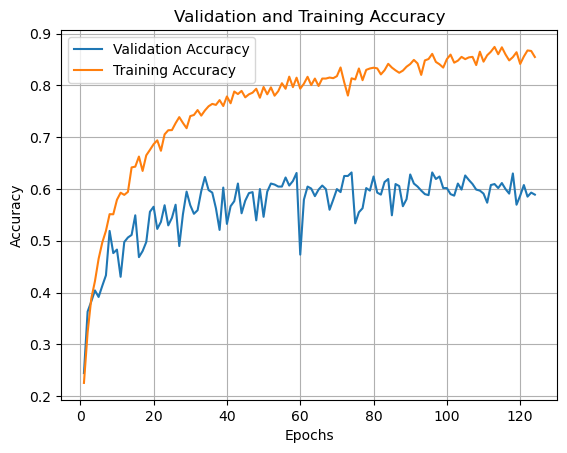

In [40]:
import matplotlib.pyplot as plt
val_accuracy = image_classification_model_500['val_accuracy']
accuracy = image_classification_model_500['accuracy']
epochs = range(1, len(val_accuracy) + 1)


plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


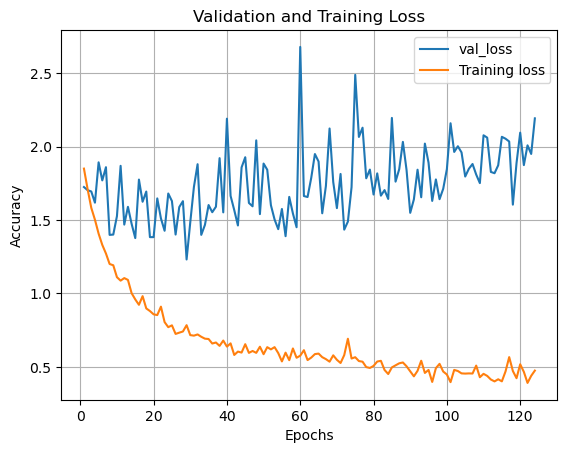

In [41]:
val_accuracy = image_classification_model_500['val_loss']
accuracy = image_classification_model_500['loss']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
import tensorflow as tf

# Load the saved model
image_classification_model_500 = tf.keras.models.load_model('./image_classification_model_500.h5')

# Now, you can use the loaded model for inference or further operations


In [65]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(images)

mean_activations = np.mean(activations, axis=(0, 1, 2))

top_activation_indices = np.argsort(mean_activations)[::-1][:10]

plt.figure(figsize=(12, 6)) 

# Estrai e visualizza le immagini di calore delle feature map
for i, index in enumerate(top_activation_indices):
    top_activation = activations[:, :, :, index]
    
    real_class = np.argmax(y_val[0])  
    predicted_class = np.argmax(predictions[0])  
    
    image_path = image_paths[0]  

    plt.subplot(2, 5, i + 1)  # Organizza le immagini in una griglia 2x5
    plt.imshow(top_activation[0, :, :], cmap='viridis')
    plt.title(f'Feature Map {index + 1}')
    plt.xlabel(f'Image Path: {image_path}', fontsize=8)
    plt.axis('off')

plt.tight_layout()  
plt.show()


1/1 [==============================] - 0s 217ms/step


NameError: name 'activations' is not defined

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

# Calcola le previsioni del modello sul set di dati di validazione
y_pred = image_classification_model_500.predict(X_val)

# Converte le previsioni in etichette di classe
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Assumendo che y_val sia one-hot encoded

# Calcola la matrice di confusione
confusion = confusion_matrix(y_val_classes, y_pred_classes)

# Calcola precision, recall e F1-score per ogni classe
report = classification_report(y_val_classes, y_pred_classes, target_names=class_names)

# Visualizza la matrice di confusione
print("Confusion Matrix:")
print(confusion)

# Visualizza il report di classificazione
print("Classification Report:")
print(report)


2023-09-10 17:55:50.861068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 15s 455ms/step
Confusion Matrix:
[[115  20  12   0   6   8]
 [  7 123  32   0   8   4]
 [  8  33 115   2  12  19]
 [  5  40  51  72   9   2]
 [  8  16  19   1 105  11]
 [ 10  28  39   3   9  75]]
Classification Report:
                 precision    recall  f1-score   support

     rick owens       0.75      0.71      0.73       161
dries van noten       0.47      0.71      0.57       174
        versace       0.43      0.61      0.50       189
  louis vuitton       0.92      0.40      0.56       179
         chanel       0.70      0.66      0.68       160
 giorgio armani       0.63      0.46      0.53       164

       accuracy                           0.59      1027
      macro avg       0.65      0.59      0.60      1027
   weighted avg       0.65      0.59      0.59      1027



In [60]:
model.predict(X_val[0:1])

1/1 [==============================] - 0s 40ms/step


array([[[[  0.       ,  42.51723  ,   0.       , ...,   0.       ,
          297.15494  ,  52.63511  ],
         [  0.       ,  15.144605 ,   0.       , ...,   0.       ,
          164.33896  ,  70.31006  ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          147.92513  ,  29.224302 ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          142.24323  ,  30.622566 ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          188.23508  ,  39.28473  ],
         [  2.6926537,  22.901773 ,   0.       , ...,   0.       ,
          275.9969   ,  57.86257  ]],

        [[  0.       ,   0.       ,   5.563524 , ...,   0.       ,
          197.93558  ,  74.695724 ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           25.978262 ,  86.16781  ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           67.52443  ,  47.280613 ],
         ...,
         [  0.       ,   0.       

In [64]:
# attention
import matplotlib.pyplot as plt
import skimage


for img,lab in zip(X_val[:10],y_val[:10]):

    print(lab)
    A,pred = Model(inputs=base_model.input, outputs=[attention,output])(img[None,...])
    print(pred[0].numpy())
    A = A[0,:,:,0].numpy()
#     print(A.shape)
    A = skimage.transform.resize(A,(224,224))


    fig, axs = plt.subplots(1,2)
    axs[0].imshow((img+124)[:,:,[2,1,0]]/255)
    axs[1].imshow(A)
    plt.show()

[0. 0. 0. 0. 0. 1.]


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'") at layer "block1_conv1". The following previous layers were accessed without issue: []